# <center> MATH&ML-8. Алгоритмы на основе деревьев решений

In [34]:
# Импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

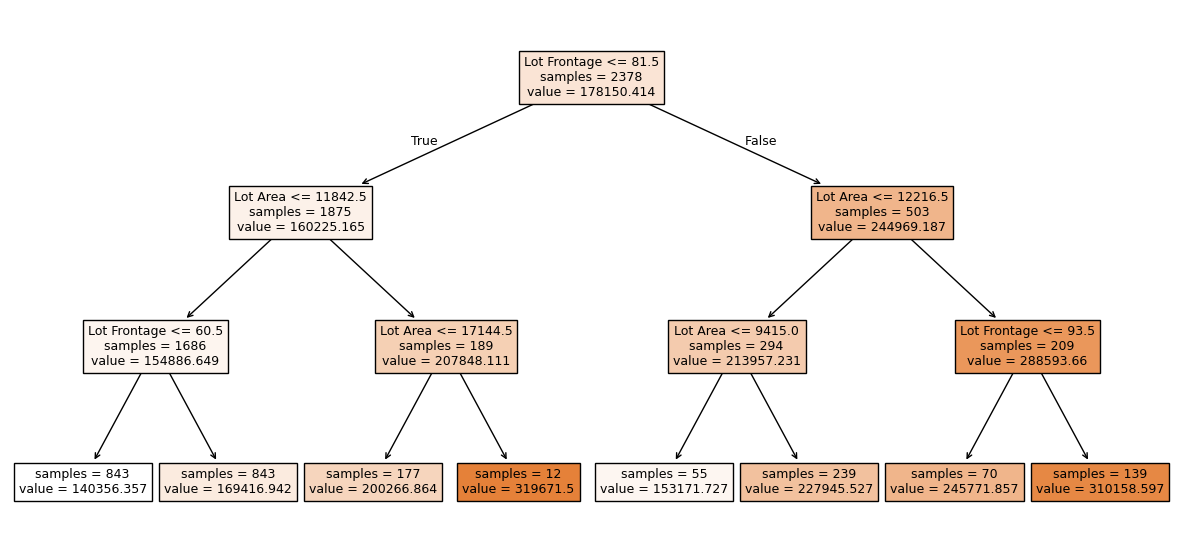

In [35]:
# Создаём обучающую выборку
ames_data = pd.read_csv('data/AmesHousing.zip')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
X = ames_data[['Lot Frontage', 'Lot Area']]
y = ames_data['SalePrice']

# Инициализируем модель дерева решений с максимальной глубиной 3 и обучаем её
dt_reg = tree.DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X.values, y)

# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_reg, #дерево решений 
    feature_names=list(X.columns), #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

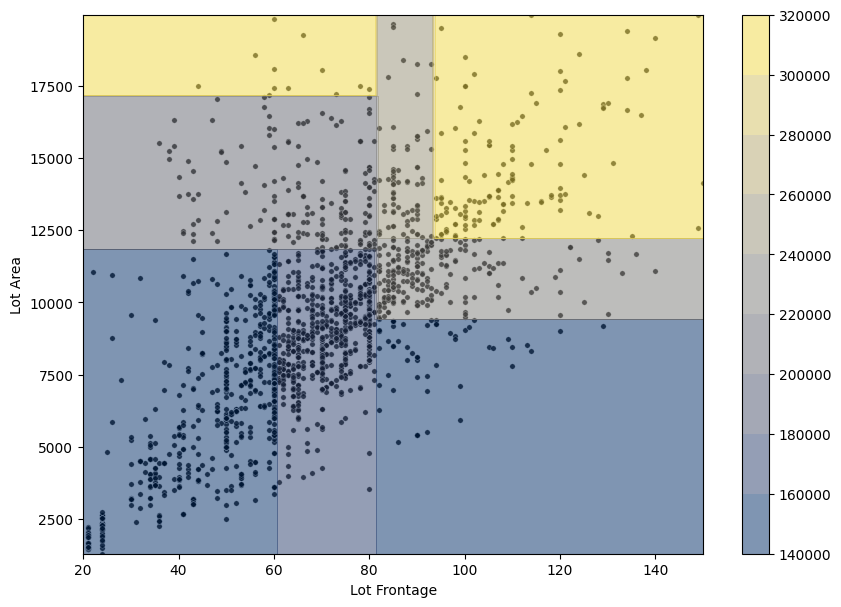

In [36]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression(X, y, dt_reg, fig)

In [37]:
# Создаём обучающую выборку    
bill_data = pd.read_csv('data/bill_authentication.zip')
X = bill_data[['Variance', 'Skewness']]
y = bill_data['Class']
bill_data

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


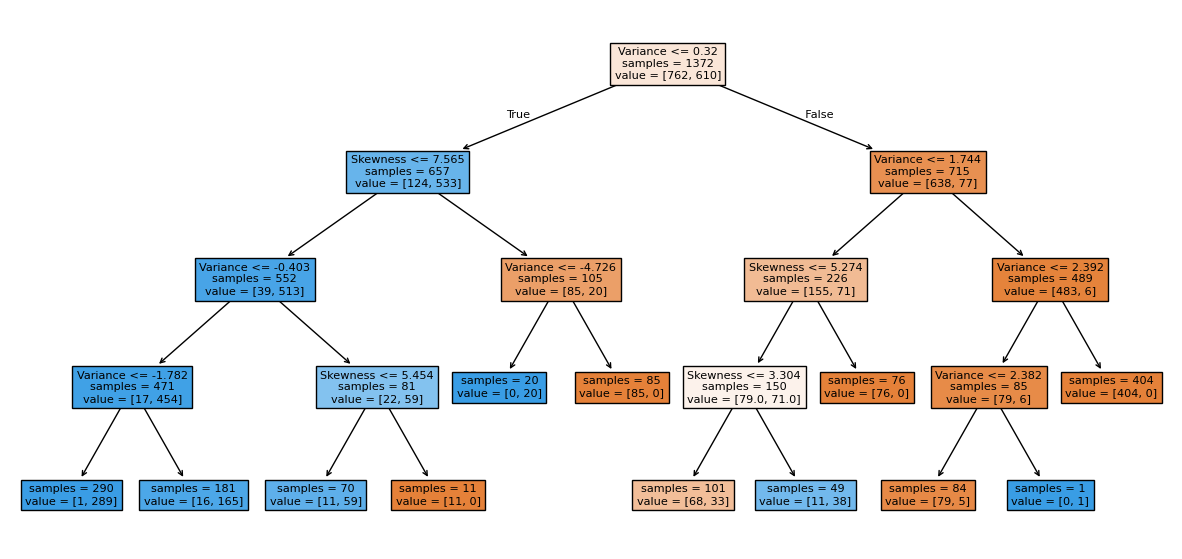

In [38]:
# Инициализируем модель дерева решений с максимальной глубиной 4 и обучаем её
dt_clf = tree.DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X.values, y)

# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_clf, #дерево решений
    feature_names=list(X.columns), #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

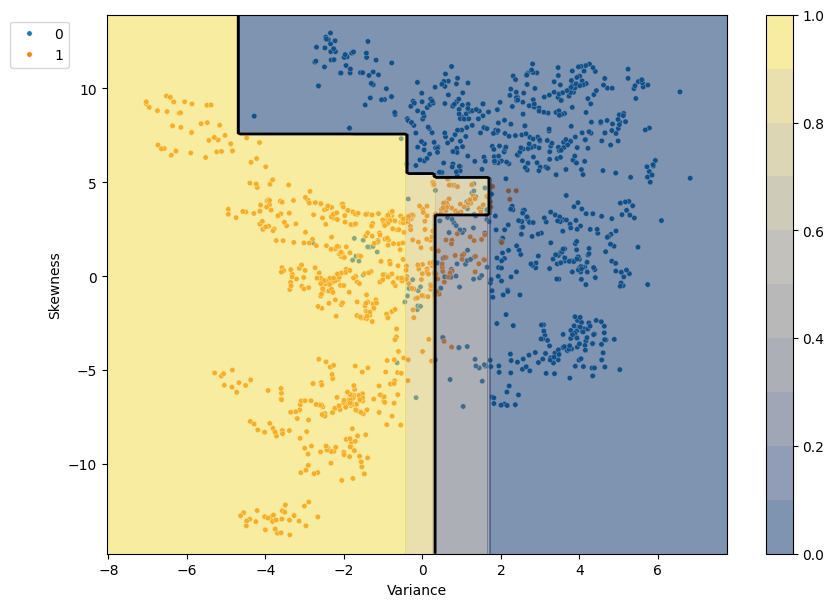

In [39]:
def plot_decision_bound_classification(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, s=15, alpha=1)
    contour = plt.contourf(xx1, xx2, probs, 10, cmap='cividis', alpha=0.5)
    bound = plt.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    fig.colorbar(contour)
    plt.legend(bbox_to_anchor=(-0.05, 1))
# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_classification(X, y, dt_clf, fig)

### Юнит 3. Алгоритм CART: параметры разбиения

In [40]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
x = data['age']
y = data['loan']

x = x.sort_values().drop_duplicates()
print(x.values)

x_roll_mean = x.rolling(2).mean()
print(x_roll_mean.values)

x_roll_mean = x_roll_mean.dropna()
print(x_roll_mean.values)

y = y[x_roll_mean.index]
y_roll_mean = y.diff()
candidates = x_roll_mean[y_roll_mean != 0]
print(candidates)

[17 18 20 25 29 31 38 49 55 64]
[ nan 17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]
[17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]
2    17.5
3    19.0
7    22.5
9    30.0
4    34.5
5    43.5
Name: age, dtype: float64


In [41]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

#Проверка
print(find_candidates_for_thresholds(data['age'], data['loan']))
print(find_candidates_for_thresholds(data['income'], data['loan']))

[17.5 19.  22.5 30.  34.5 43.5]
[23.5 34.5 36.5 48.  64.5 72. ]


In [42]:
# Задание 3.4

ames_data = pd.read_csv('data/AmesHousing.zip')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)
x1 = ames_sample['Lot Frontage']
y = ames_sample['SalePrice']
print(find_candidates_for_thresholds(x1, y))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]


In [43]:
# Задание 3.5
# Недостающая часть из задания 3.4

x2 = ames_sample['Lot Area']
print(find_candidates_for_thresholds(x2, y))

[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]
